In [ ]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

import os
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
batch_size = 64
epochs = 10
log_interval = 100
learning_rate = 1e-3
latent_dim = 100 # 값이 크면 모델이 더 많은 정보를 잠재 공간에 인코딩할 수 있지만, 너무 큰 값은 과적합 초래.

In [ ]:
seed = 975
torch.manual_seed(seed)
path = 'mnist_checkpoint.pth'

In [ ]:
device = torch.device("cuda")
device

In [ ]:
transform = transforms.ToTensor()
train_loader = DataLoader(datasets.MNIST('../../data', train=True, download=True, transform=transform),
                          batch_size=batch_size, shuffle=True)
test_loader = DataLoader(datasets.MNIST('../../data', train=False, download=True, transform=transform),
                         batch_size=batch_size, shuffle=False)

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, latent_dim),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # Latent space
        self.fc_mu = nn.Linear(latent_dim, latent_dim)  # mu
        self.fc_logvar = nn.Linear(latent_dim, latent_dim)  # logvar

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64 * 7 * 7),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [ ]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [ ]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        torch.save(model.state_dict(), path)

    print('====> Train set loss: {:.4f}'.format(
          train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:  # 첫 번째 배치에 대해서만 이미지 시각화
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n], recon_batch.view(batch_size, 1, 28, 28)[:n]])
                comparison = comparison.cpu().numpy()
                fig, axes = plt.subplots(2, n, figsize=(10, 2))
                for idx in range(n):
                    axes[0, idx].imshow(comparison[idx].reshape(28, 28), cmap='gray')
                    axes[0, idx].axis('off')
                    axes[1, idx].imshow(comparison[idx + n].reshape(28, 28), cmap='gray')
                    axes[1, idx].axis('off')
                plt.show()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [ ]:
if __name__ == "__main__":
    for epoch in tqdm(range(1, epochs+1)):
        train(epoch)
        test(epoch)
        with torch.no_grad():
            sample = torch.randn(64, latent_dim).to(device) # 64 -> 샘플로 생성할 이미지 갯수
            sample = model.decode(sample).cpu()
            fig, ax = plt.subplots(figsize=(10, 10))
            ax.set_xticks([])
            ax.set_yticks([])
            ax.imshow(make_grid(sample.view(64, 1, 28, 28)).permute(1, 2, 0))
            plt.show()

In [ ]:
model.load_state_dict(torch.load(path))

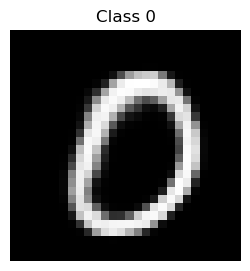

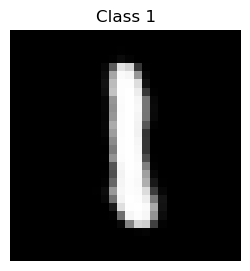

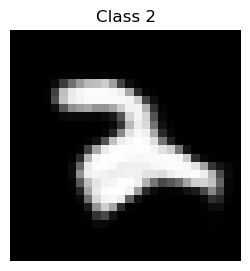

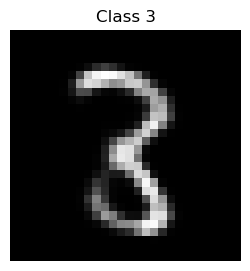

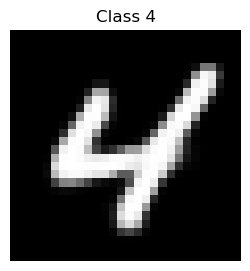

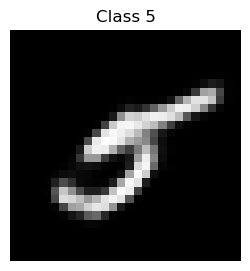

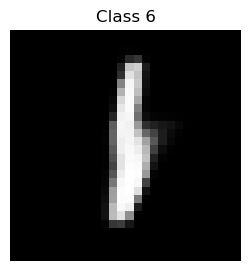

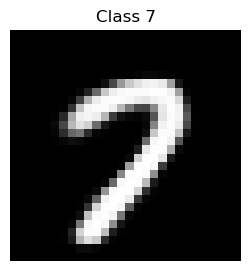

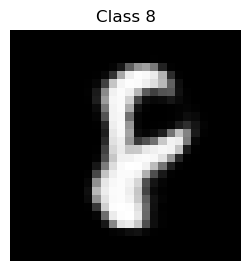

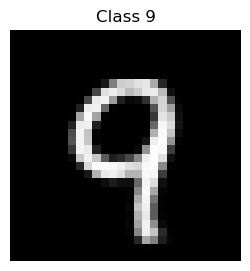

In [32]:
def visualize_class_images(model, data_loader, device, n_classes=10):
    class_mu = []
    class_logvar = []

    model.eval()
    with torch.no_grad():
        for i in range(n_classes):
            # 데이터셋의 모든 배치에서 특정 클래스에 속하는 이미지들을 모아 하나의 텐서로
            class_images = torch.cat([data[labels == i].to(device) for data, labels in data_loader], dim=0)
            mu, logvar = model.encode(class_images)
            class_mu.append(mu)
            class_logvar.append(logvar)
            std = torch.exp(0.5 * class_logvar[i])
            eps = torch.randn_like(std)
            z = class_mu[i] + eps * std
            sample = model.decode(z).cpu()
            sample = sample.numpy()
            plt.figure(figsize=(3, 3))
            plt.imshow(sample[0][0], cmap='gray')
            plt.title(f"Class {i}")
            plt.axis('off')
            plt.show()

# 학습 후 이 함수 호출
visualize_class_images(model, train_loader, device)


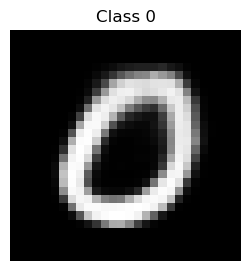

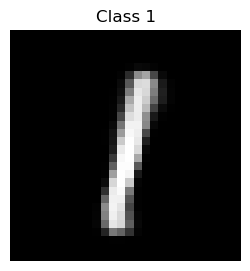

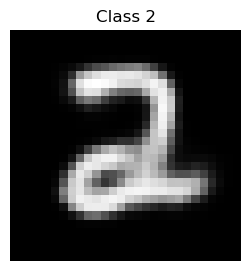

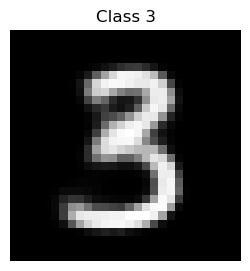

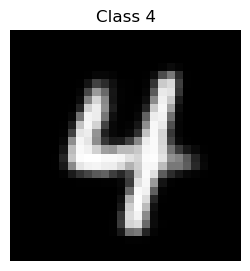

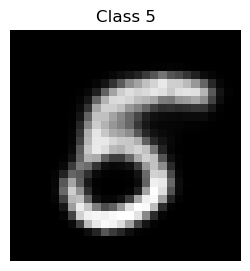

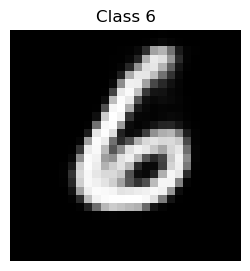

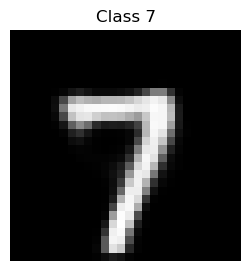

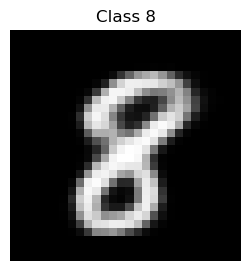

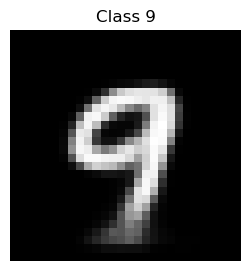

In [33]:
def visualize_class_images(model, data_loader, device, n_classes=10):
    class_mu = []
    class_logvar = []

    model.eval()
    with torch.no_grad():
        for i in range(n_classes):
            mu_list = []
            logvar_list = []
            for data, labels in data_loader:
                # 데이터셋 배치들의 평균과 분산을 각각 구함
                class_data = data[labels == i].to(device)
                if len(class_data) > 0:
                    mu, logvar = model.encode(class_data)
                    mu_list.append(mu)
                    logvar_list.append(logvar)
            
            # 각 클래스별로 모든 배치의 평균과 분산을 계산
            class_mu.append(torch.cat(mu_list).mean(0))
            class_logvar.append(torch.cat(logvar_list).mean(0))

            std = torch.exp(0.5 * class_logvar[i])
            eps = torch.randn_like(std)
            z = class_mu[i] + eps * std
            sample = model.decode(z.unsqueeze(0)).cpu()
            sample = sample.numpy()
            plt.figure(figsize=(3, 3))
            plt.imshow(sample[0][0], cmap='gray')
            plt.title(f"Class {i}")
            plt.axis('off')
            plt.show()

visualize_class_images(model, train_loader, device)
